##[Back to homepage](index.html)
#Examples on a yeast Hi-C contact map

We give examples on how to use BNMF to study real Hi-C data. Yeast Hi-C contact maps are provided by [Noble Research Lab](http://noble.gs.washington.edu/proj/yeast-architecture/sup.html). In the paper, we did the experiment on *HindIII interactions at FDR 1%* at 10kb resolution.

Here, we only want to show the procedure and so choose the smallest Hi-C contact map that is contained in our package. Please check Noble lab's website for the full data set.

### Import required modules

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from contact_map import ContactMap
import numpy as np

### Create an object for the contact map

In [21]:
map1 = ContactMap('demo-yeast')

Load the genome information. Basically, we only need to know the chromosome lengths and how to map chromosome names to unique integers. In the file we provided, they are
```
chr start end      name
1   0     230218   chrI
2   0     813184   chrII
...
```
which means chrI in yeast is shown as number 1 with a length of 230,218 base-pairs.
All lines starting with `#` will be ignored.

In [22]:
map1.genome_info('yeast_chr_len.txt')

Read file yeast_chr_len.txt None column and row [1,17)
chrI with index 1
chrII with index 2
chrIII with index 3
chrIV with index 4
chrV with index 5
chrVI with index 6
chrVII with index 7
chrVIII with index 8
chrIX with index 9
chrX with index 10
chrXI with index 11
chrXII with index 12
chrXIII with index 13
chrXIV with index 14
chrXV with index 15
chrXVI with index 16
Read file yeast_chr_len.txt 0 column and row [1,17)
Read file yeast_chr_len.txt 1 column and row [1,17)
Read file yeast_chr_len.txt 2 column and row [1,17)


Then, we can import contact links from Hi-C data. The format for long-range interaction files is like:
```
chr1 locus1 chr2 locus2 freq
1    3437   2    9409   7
1    31834  2    301976 6
...
```
which means location `chrI:3437` and location `chrII:9409` have 7 interactions and so on. Multiple interaction files can be imported in sequence.

In [23]:
datafiles = ['HindIII_intersect_EcoRI_fdr0.01_inter.txt', 
             'HindIII_intersect_EcoRI_fdr0.01_intra.txt']
for datafile in datafiles:
    map1.add_interactions(datafile)

Add interaction file HindIII_intersect_EcoRI_fdr0.01_inter.txt
Read file HindIII_intersect_EcoRI_fdr0.01_inter.txt 0 column and row [1,31838)
Read file HindIII_intersect_EcoRI_fdr0.01_inter.txt 1 column and row [1,31838)
Read file HindIII_intersect_EcoRI_fdr0.01_inter.txt 2 column and row [1,31838)
Read file HindIII_intersect_EcoRI_fdr0.01_inter.txt 3 column and row [1,31838)
Read file HindIII_intersect_EcoRI_fdr0.01_inter.txt 4 column and row [1,31838)
Add interaction file HindIII_intersect_EcoRI_fdr0.01_intra.txt
Read file HindIII_intersect_EcoRI_fdr0.01_intra.txt 0 column and row [1,27294)
Read file HindIII_intersect_EcoRI_fdr0.01_intra.txt 1 column and row [1,27294)
Read file HindIII_intersect_EcoRI_fdr0.01_intra.txt 2 column and row [1,27294)
Read file HindIII_intersect_EcoRI_fdr0.01_intra.txt 3 column and row [1,27294)
Read file HindIII_intersect_EcoRI_fdr0.01_intra.txt 4 column and row [1,27294)


We group those interations into a contact map with a fixed bin size. We set a large bin size (40kb) in this example through the parameter `binsize=40e3`.

In [24]:
map1.create_binnedmap(binsize=40e3)

Create contact map of shape (309, 309)


Let's see what the contact map looks like.

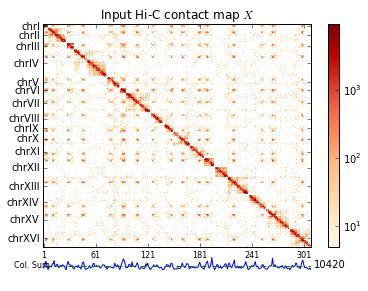

In [25]:
map1.plot_map(title='Input Hi-C contact map $X$');

### Apply BNMF on it

We have make all computations to be automatic, by calling the `decompose_auto` function.

In [26]:
map1.decompose_auto();

dim_num = 39
> Solve NMF for size (309, 309) <class 'numpy.matrixlib.defmatrix.matrix'>
Matrix density is 33.7232119479 and mask 0
Optimize available solution for H!
Optimize available solution for S!
Lambda for NMF-PoissonManifoldEqual is set to 1
Initial objective is 1500566.84456
Current objective is 1500683.80264;  
Density of H is 0.449; Density of S is 0.132;
The best NMF-PoissonManifoldEqual objective for NMF is 1500683.80264 with r=39 after 4 iterations.


It creates a file `demo-yeast_nmf.npz` that saves the matrix factors which will be loaded when decomposing the contact matrix with same parameters.

Having the matrix factors, we can sort the cluster order according to their major bins in genome.

In [27]:
map1.sort_groups();

Now, we check the factorization solution one by one.

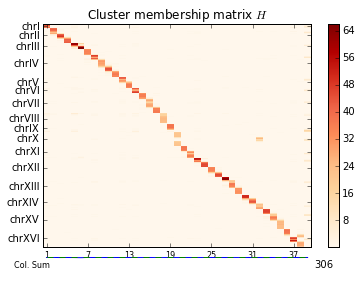

In [28]:
map1.plot_map(map1.contact_group, vmin=0.1, log=False, title='Cluster membership matrix $H$');

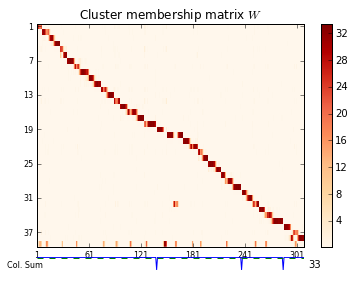

In [29]:
map1.plot_map(map1.group_map * map1.contact_group.T, vmin=0.1, log=False, title='Cluster membership matrix $W$');

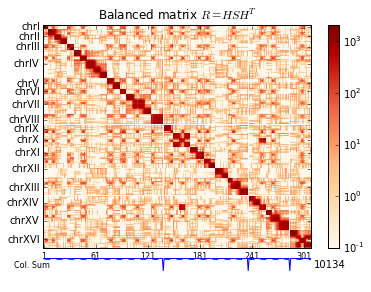

In [30]:
map1.plot_map(map1.contact_group * map1.group_map * map1.contact_group.T, vmin=0.1, title='Balanced matrix $R=HSH^T$');

Also, we can check the position bias that is corrected.

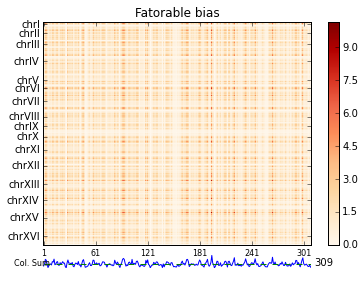

In [31]:
map1.plot_map(np.outer(map1.bias_vector, map1.bias_vector), log=False, title='Fatorable bias');

###Test clustering enrichment
We can test whether a type of genomic feature is enriched in those clusters. Again, we used the list of early origin sites from Noble lab's website.

To do the test, we need to transform the genomic locations into the bin indexes. According to the file format, we have several parameters.
- `st=0`: read the file by skipping the first 0 lines
- `ch=0`: chromosome indexes are saved in the column of index 0
- `po=1`: positions are saved in the column of index 1
- `nm=0`: the location names are saved in the column of index 0 (we don't have location's name)

In [32]:
idx, names = map1.get_locations('origins_nonCDR_early.txt', st=0, ch=0, po=1, nm=0)

Read file origins_nonCDR_early.txt 0 column and row [0,76)
Read file origins_nonCDR_early.txt 1 column and row [0,76)
Read file origins_nonCDR_early.txt 0 column and row [0,76)


We test the bins list using the area under the ROC curve (AUC).

In [33]:
srt, val, pval = map1.test_enrichment(idx, method='AUC')

`val` saves the AUC values and `pval` are the corresponding p-values. `srt` gives the indexes from the most significant cluster to the least one.

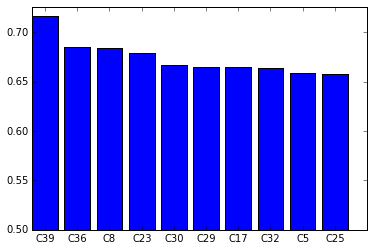

In [34]:
plt.bar(np.arange(10), val[srt[:10]]);
plt.xticks(np.arange(0.4,11,1), ['C%s'%(i+1) for i in srt[:10]]);
plt.ylim([0.5, val.max()+0.01]);

Let's check the cluster with the largest AUC in the whole contact map.

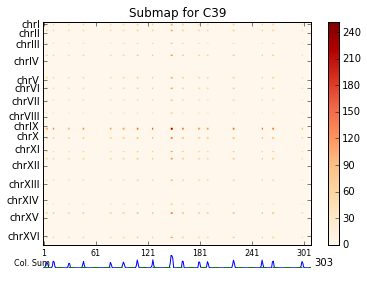

In [35]:
map1.plot_map(map1.contact_group[:,srt[0]]*map1.contact_group[:,srt[0]].T, log=False, title='Submap for C%s'%(srt[0]+1));

We can see the most enriched cluster is the one for centromeres.
##[Back to homepage](index.html)